In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D,LSTM
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 559198907314754827
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6681249765196939266
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14073233495717268353
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

 data exploration

<AxesSubplot:>

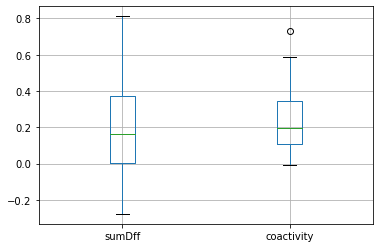

In [18]:
# df = []
# for m in getMiceList(Files[0]):
#     data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
#     for s in data.keys():
#         speed = smooth(data[s]['speed']['speed'],20)
#         dff = np.nansum(data[s]['trace']['dff'],axis=0,keepdims=True)
#         ca = np.nansum(getOnsetOrPeriod(m,s,'Pre','caOnset_Hf'),axis=0,keepdims=True)
#         if np.max(speed.shape) != np.max(dff.shape):
#             endI = np.min([np.max(speed.shape),np.max(dff.shape),np.max(ca.shape)])-1
#         df.append({'sumDff':sci.stats.pearsonr(dff[0,:endI],speed[:endI])[0],'coactivity':sci.stats.pearsonr(ca[0,:endI],speed[:endI])[0]})
# df = pd.DataFrame(df)
df.boxplot()


cleaning up trace data
cleaning up speed data
0761 0761_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
1231 1231_BaselineA
1231 1231_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
1793 1793_BaselineA
cleaning up trace data
cleaning up speed data
2976 2976_BaselineA
2976 2976_BaselineL
2976 2976_BaselineS
cleaning up trace data
cleaning up speed data
2980 2980_BaselineL
cleaning up trace data
cleaning up speed data
2981 2981_BaselineL
2981 2981_BaselineS
cleaning up trace data
cleaning up speed data
4539 4539_day0
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
8815 8815_BaselineS


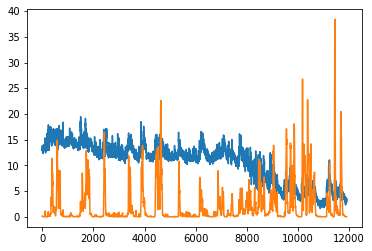

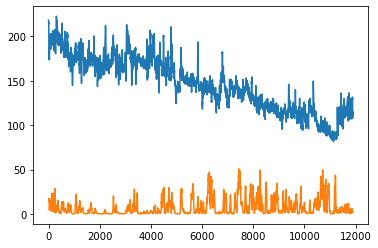

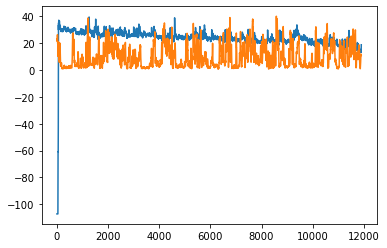

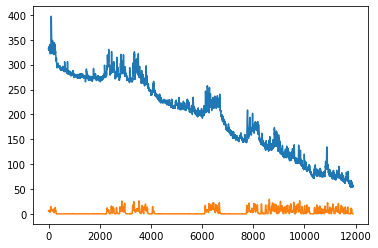

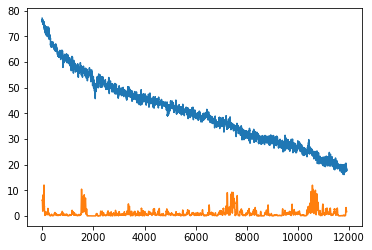

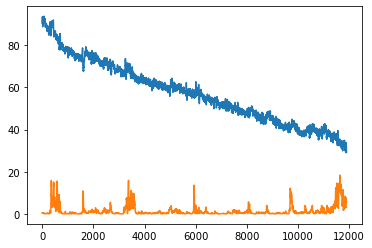

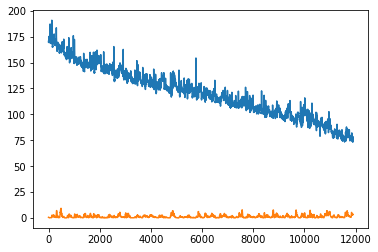

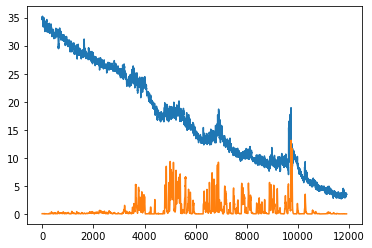

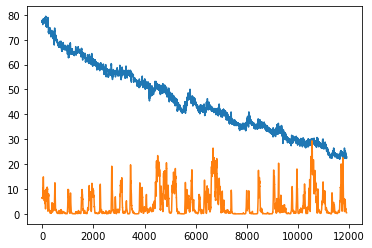

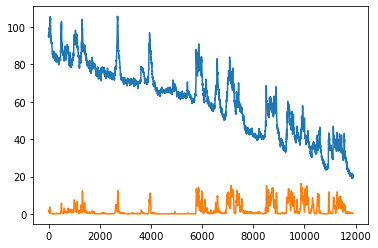

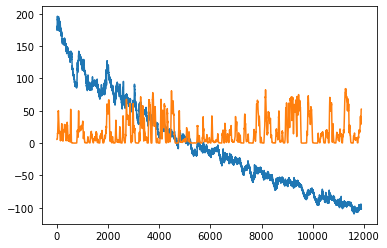

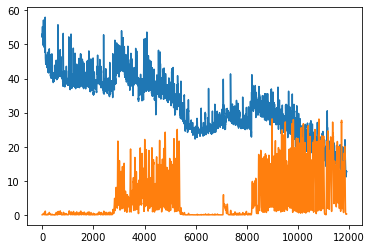

In [20]:
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    for s in data.keys():
        speed = smooth(data[s]['speed']['speed'],20)
        dff = np.nansum(data[s]['trace']['dff'],axis=0,keepdims=True)
        ca = np.nansum(getOnsetOrPeriod(m,s,'Pre','caOnset_Hf'),axis=0,keepdims=True)
        if np.max(speed.shape) != np.max(dff.shape):
            endI = np.min([np.max(speed.shape),np.max(dff.shape),np.max(ca.shape)])-1
        if sci.stats.pearsonr(dff[0,:endI],speed[:endI])[0] < 0:
            print(m,s)
            fix, ax = plt.subplots(1,1)
            ax.plot(dff[0,:endI])
            ax.plot(speed[:endI])


cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
1208 1208_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
1231 1231_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
1253 1253_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
8430 8430_BaselineL
8430 8430_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
8815 8815_BaselineA
8815 8815_BaselineS


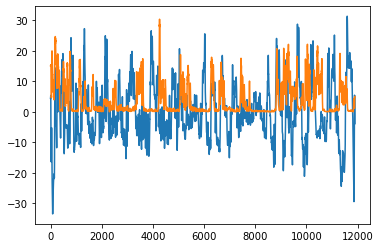

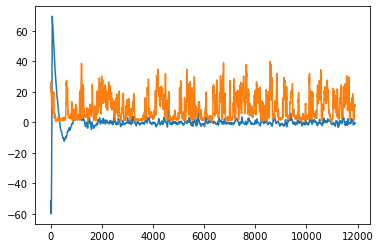

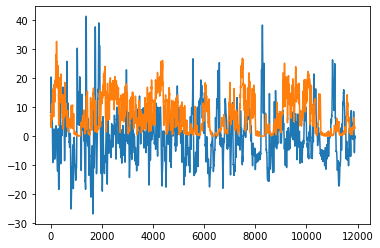

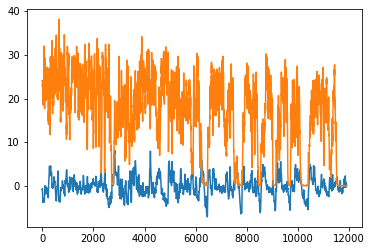

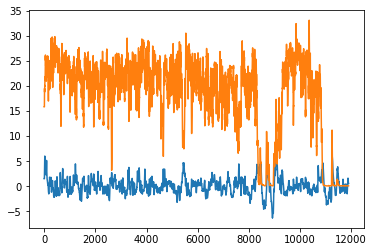

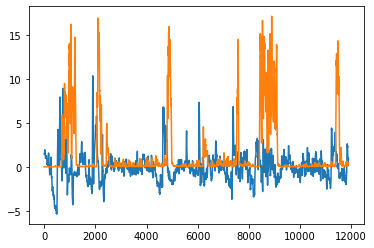

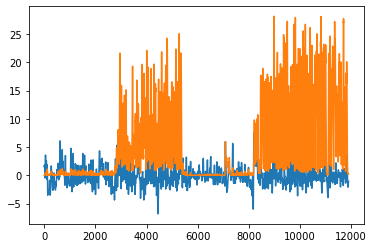

In [5]:
df = []
ignoreSess = []
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    for s in data.keys():
        speed = smooth(data[s]['speed']['speed'],20)
        dff =  butter_bandpass_filter(smooth(np.nansum(data[s]['trace']['dff'],axis=0,keepdims=True),20),0.02,9.9,20)
        ca = np.nansum(getOnsetOrPeriod(m,s,'Pre','caOnset_Hf'),axis=0,keepdims=True)
        if np.max(speed.shape) != np.max(dff.shape):
            endI = np.min([np.max(speed.shape),np.max(dff.shape),np.max(ca.shape)])-1
        if sci.stats.pearsonr(dff[:endI],speed[:endI])[0] < 0:
            print(m,s)
            fix, ax = plt.subplots(1,1)
            ax.plot(dff[:endI])
            ax.plot(speed[:endI])
            ignoreSess.append(s)
        else:
            df.append({'sumDff':sci.stats.pearsonr(dff[:endI],speed[:endI])[0],'coactivity':sci.stats.pearsonr(ca[0,:endI],speed[:endI])[0]})
df = pd.DataFrame(df)


sumDff        0.300348
coactivity    0.260298
dtype: float64

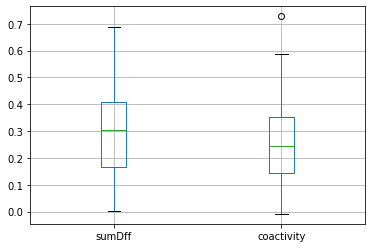

In [36]:
df.boxplot()
df.mean()

In [5]:
df = []
ignoreSess = []
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    for s in data.keys():
        speed = smooth(data[s]['speed']['speed'],200)
        dff =  butter_bandpass_filter(smooth(np.nansum(data[s]['trace']['dff'],axis=0,keepdims=True),200),0.02,9.9,20)
        ca = np.nanmean(getOnsetOrPeriod(m,s,'Pre','caOnset_Hf'),axis=0,keepdims=True)
        ca = smooth(ca,200)
        if np.max(speed.shape) != np.max(dff.shape):
            endI = np.min([np.max(speed.shape),np.max(dff.shape),np.max(ca.shape)])-1
        if sci.stats.pearsonr(dff[:endI],speed[:endI])[0] < 0:
            print(m,s)
            fix, ax = plt.subplots(1,1)
            ax.plot(dff[:endI])
            ax.plot(speed[:endI])
            ignoreSess.append(s)
        else:
            df.append({'sumDff':sci.stats.pearsonr(dff[:endI],speed[:endI])[0],'coactivity':sci.stats.pearsonr(ca[:endI],speed[:endI])[0]})
df = pd.DataFrame(df)


sumDff        0.305004
coactivity    0.357920
dtype: float64

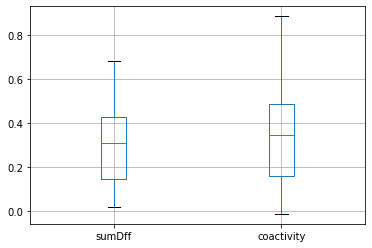

In [187]:
df.boxplot()
df.mean()

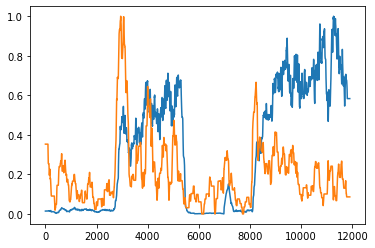

In [192]:
dff = (dff-np.min(dff))/(np.max(dff)-np.min(dff))
speed = (speed-np.min(speed))/(np.max(speed)-np.min(speed))
ca = (ca-np.min(ca))/(np.max(ca)-np.min(ca))
# plt.plot(dff)
plt.plot(speed)
plt.plot(ca)


<h3>train LSTM co-activity -> speed </h3>
ignore unusal sessions 

In [106]:
def center(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

f = h5py.File('E:\\normalized_step2_processed2.hdf5','a')
df = pd.DataFrame(columns= ["Mouse","Session","Period","length","maxN"])
dt = 0.05
maxSpeed = []
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    for sess in data:
        speed = smooth(data[sess]['speed']['speed'],200)
        maxSpeed.append(np.max(speed))
maxSpeed = np.mean(maxSpeed)
print(maxSpeed)
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
    for sess in data.keys():
        speed = data[sess]['speed']['speed']
        speed = speed/maxSpeed
        speed[speed>1] = 1
        dff = data[sess]['trace']['dff']
        for n in range(dff.shape[0]):
            dff[n,:] = center(butter_bandpass_filter(smooth(dff[n,:],200),0.02,9.9,20))
#         mx = np.max(dff,axis = 1)
#         mn = np.min(dff,axis = 1)
#         dff = (dff.T-mn)/(mx-mn)
#         dff = dff.T
        ca = center(smooth(np.nanmean(getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf'),axis=0,keepdims=True),200))

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        try:
            g = f.create_group(sess)
            g['dff'] = dff
            g['mdff'] = np.mean(dff,axis=0)
            g['speed'] = speed
            g['ca'] = ca
        except:
            del f[sess]
            g = f.create_group(sess)
            g['dff'] = dff
            g['mdff'] = np.mean(dff,axis=0)
            g['speed'] = speed
            g['ca'] = ca
        
        df = df.append({"Mouse":m,"Session":sess,'Period':periodCalc(day),"length":np.max(speed.shape),"maxN":np.min(dff.shape)},ignore_index=True)
        
df.to_csv('availableData_all_coActivity.csv')  
f.close()

cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
19.201455981883623
cleaning up trace data
cleaning up speed data


C:\Users\dzemel\Miniconda3\envs\LSTM\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data


In [6]:
miceList = getMiceList(Files[0])
miceList.remove('1253') # only healthy data - must be in training
miceList.remove('1231') # only healthy data - must be in training
miceList.remove('8430') # very abnormal running behavour
mOrder = np.random.permutation(len(miceList))

mTrain = [1231, 1253]
mTest =[int(miceList[i]) for i in mOrder[:2]]
mTrain = mTrain+ [int(miceList[i]) for i in mOrder[2:]]

print(mTrain,mTest)
# print(miceList[mOrder[:2]])

[1231, 1253, 1793, 8803, 2976, 4539, 2980, 7584, 1236, 1222, 7909, 2981, 761] [8815, 1208]


In [7]:
def prepData(segN,overlap,df):
    df2 = df
    df2['start'] = pd.Series([[]] * len(df2), index=df2.index)
    df2['end'] = pd.Series([[]] * len(df2), index=df2.index)
    for l in df.length.unique():
        a = np.asarray([[i,i + segN] for i in range(0, l-(segN-overlap),int(segN-overlap))])
        df2.loc[df2.length==l,'start'] = pd.Series([a[:,0]] * len(df2), index=df2.index)
        df2.loc[df2.length==l,'end'] =  pd.Series([a[:,1]] * len(df2), index=df2.index)
    lst_col = 'start'

    lst_col = 'start'
    lst_col2 = 'end'
    df3 = pd.DataFrame({
        col:np.repeat(df2[col].values, df2['start'].str.len())
        for col in df2.columns.difference(['start','end'])
    }).assign(**{'start':np.concatenate(df2['start'].values)}).assign(**{'end':np.concatenate(df2['end'].values)})[df2.columns.tolist()]
    return df3

In [8]:
df = pd.read_csv('availableData_all_coActivity.csv')
df = df[~df.Session.isin(ignoreSess)]
N = 100 # not relevant unless adding dff
dt = 0.05
segN = int(np.ceil(5/dt))
overlap = segN-1

df = df[(df.Period=='Healthy')]
df = prepData(segN,overlap,df)
df = df[df.end<11850]

with h5py.File('E:\\normalized_step2.hdf5','r') as f:
    df['label'] = df.apply(lambda row: f[row.Session]['speed'][0,np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )

# df.to_csv('data_segN5s_healthy_coactivity.csv')
# df = pd.read_csv('data_segN20_healthy_coactivity.csv')
# df = pd.read_csv('data_segN5s_healthy_coactivity.csv')

testData = df[df.Mouse.isin(mTest)]
trainData = df[df.Mouse.isin(mTrain)]
validate = trainData[trainData.end>(540/dt)]
trainData = trainData.drop(validate.index)
print(len(trainData),len(validate),len(testData))

395937 38813 35250


In [11]:
dataVersion = 'v1_n_ca'
#save data partition: 
trainData.to_csv('dataPartition_'+dataVersion+'_train.csv')
validate.to_csv('dataPartition_'+dataVersion+'_val.csv')
testData.to_csv('dataPartition_'+dataVersion+'_test.csv')

In [281]:
# debugging why net isn't fitting - trying a simpler dataset from a blog
dataset = pd.read_csv('E:\\NN\\LSTMtestData.csv')
dataset = dataset.values
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def loadTrain_test(data,butchSize,N):
    # sampleSize = batchSize/3
    data = pd.DataFrame(train,columns = ['date','val'])
    minV = data.val.min()
    maxV = data.val.max()
    data['val'] = data.val.apply(lambda x: (x-minV)/(maxV-minV))
    while True: 
        #data.sample(frac=1)
        for i, g in data.iloc[N:].groupby(np.arange(len(data.iloc[N:])) // butchSize):
            batch = g
            labels = batch.apply(lambda row: data.iloc[int(row.name)-N].val if int(row.name)-N>=0 else None,axis=1 )
            labels = np.stack(labels.values)
            dataPoint = g.val.values
#             dataPoint = [np.sum(row[:,np.random.randint(0,row.shape[0],size=N)],axis=1,keepdims=True) for row in dataPoint]
            try:
                dataPoint = np.stack(dataPoint).reshape(20,1,1)
            except:
                continue
            yield (dataPoint,labels)
    f.close()

In [285]:
for ind,(dataP,label) in enumerate(loadTrain_test(train,20,5)):
    print(label.shape,dataP.shape)
    if ind == 1:
        break

(20,) (20, 1, 1)
(20,) (20, 1, 1)


In [87]:
testData

,Unnamed: 0,Mouse,Session,Period,length,maxN,start,end,label
392646,154,7909,7909_Baseline2A,Healthy,11899,520,0,200,0.141435
392647,154,7909,7909_Baseline2A,Healthy,11899,520,1,201,0.278683
392648,154,7909,7909_Baseline2A,Healthy,11899,520,2,202,0.389737
392649,154,7909,7909_Baseline2A,Healthy,11899,520,3,203,0.274225
392650,154,7909,7909_Baseline2A,Healthy,11899,520,4,204,0.144592
...,...,...,...,...,...,...,...,...,...
475679,188,8803,8803_BaselineS,Healthy,11899,153,11645,11845,0.000000
475680,188,8803,8803_BaselineS,Healthy,11899,153,11646,11846,0.000000
475681,188,8803,8803_BaselineS,Healthy,11899,153,11647,11847,0.000000
475682,188,8803,8803_BaselineS,Healthy,11899,153,11648,11848,0.000000


In [9]:
def loadTrain(data,butchSize,N):
    with h5py.File('E:\\normalized_step2_processed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        while True: 
            data = data.sample(frac=1)
            dictData = data.to_dict('records')
            labels = []
            dataPoint =[]
            for i in range(1,len(dictData)):
                labels.append(dictData[i]['label'])
                dp = [f[dictData[i]['Session']]['ca'][dictData[i]['start']:dictData[i]['end']]]
                dp.append(f[dictData[i]['Session']]['mdff'][dictData[i]['start']:dictData[i]['end']])           
                dp = np.stack(dp).T
                dataPoint.append(dp)
                if i%butchSize==0:# and i>0:
                    labels = np.stack(labels)
                    dataPoint = np.stack(dataPoint)
    #                     dataPoint = np.expand_dims(dataPoint, axis=2)
                    yield (dataPoint,labels)
                    labels = []
                    dataPoint = []


In [10]:
def loadTest(data,butchSize,N):
    with h5py.File('E:\\normalized_step2_processed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(1,len(dictData)):
            labels.append(dictData[i]['label'])
            dp = [f[dictData[i]['Session']]['ca'][dictData[i]['start']:dictData[i]['end']]]
            dp.append(f[dictData[i]['Session']]['mdff'][dictData[i]['start']:dictData[i]['end']])           
            dp = np.stack(dp).T
            dataPoint.append(dp)
            if i%butchSize==0:# and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
#                     dataPoint = np.expand_dims(dataPoint, axis=2)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []


In [26]:
for ind,(dataP,label) in enumerate(loadTest(testData,butchSize,N)):
    print(label.shape,dataP.shape)#,np.max(dataP),np.min(dataP))
    if ind == 1:
        break

(512,) (512, 100, 2)
(512,) (512, 100, 2)


In [111]:
for ind,(dataP,label) in enumerate(loadTrain(validate,butchSize,N)):
    print(label.shape,dataP.shape)#,sci.stats.pearsonr(np.mean(dataP[:,:,0],axis=1), label))
#     plt.scatter(np.mean(dataP[:,:,0],axis=1), label)
    if ind == 2:
        break

(512,) (512, 200, 2)
(512,) (512, 200, 2)
(512,) (512, 200, 2)


In [51]:
del model  

In [11]:
butchSize = 512
N = 100

In [52]:
# model for v4
model = Sequential()
model.add(LSTM(10, input_shape=(segN, 2)))#, return_sequences = True))
model.add(Dropout(0.2))
# model.add(LSTM(25))#, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(25))
# model.add(Dropout(0.2))
# model.add(Dense(30))
# model.add(Dense(10))
model.add(Dense(1,activation="relu"))

In [53]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                520       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# largly based on code published by "Julio Daniel Reyes" on stack overflow
# https://stackoverflow.com/questions/46619869/how-to-specify-the-correlation-coefficient-as-the-loss-function-in-keras
from tensorflow.keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + 0.00000001)
    
    r = r +1 # make sure that all negative correlations are as high loss as possible
    r = K.maximum(K.minimum(r, 2.0), 0) 
    
    return 2 - r

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=350,
    mode='min',
    restore_best_weights=False)

check_point = tf.keras.callbacks.ModelCheckpoint(
    'E:\\'+modelName+'_bestWeights.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

trainData2 = trainData.sample(frac=1) #to run this faster, just see if we get anything
validate2 = validate.sample(frac=1)
modelName = 'CoActivityAndDff2speed_1l_10uadam'

model.compile(optimizer='adam',
              loss=correlation_coefficient_loss,
              metrics=['mse'])

stepTrain=len(trainData2)//butchSize #just to test something is happening
stepValidate=len(validate2)//butchSize

history = model.fit(loadTrain(trainData2,butchSize,N),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate2,butchSize,N),
                    validation_steps=stepValidate,
                    epochs=1500,callbacks=[early_stopping,check_point])#,


Epoch 1/1500
773/773 [==============================] - 219s 281ms/step - loss: 0.6934 - mse: 0.1869 - val_loss: 0.6624 - val_mse: 0.1270

Epoch 00001: val_loss improved from inf to 0.66237, saving model to E:\CoActivityAndDff2speed_1l_10uadam_bestWeights.h5
Epoch 2/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6712 - mse: 0.2212 - val_loss: 0.6466 - val_mse: 0.2095

Epoch 00002: val_loss improved from 0.66237 to 0.64657, saving model to E:\CoActivityAndDff2speed_1l_10uadam_bestWeights.h5
Epoch 3/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.6678 - mse: 0.2963 - val_loss: 0.6479 - val_mse: 0.2266

Epoch 00003: val_loss did not improve from 0.64657
Epoch 4/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.6661 - mse: 0.3019 - val_loss: 0.6468 - val_mse: 0.2828

Epoch 00004: val_loss did not improve from 0.64657
Epoch 5/1500
773/773 [==============================] - 222s 287ms/step - loss: 0.6638 - mse: 0.32

773/773 [==============================] - 217s 282ms/step - loss: 0.6357 - mse: 0.4863 - val_loss: 0.6287 - val_mse: 0.4373

Epoch 00041: val_loss did not improve from 0.61871
Epoch 42/1500
773/773 [==============================] - 218s 282ms/step - loss: 0.6351 - mse: 0.4905 - val_loss: 0.6293 - val_mse: 0.3353

Epoch 00042: val_loss did not improve from 0.61871
Epoch 43/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6351 - mse: 0.4796 - val_loss: 0.6222 - val_mse: 0.3530

Epoch 00043: val_loss did not improve from 0.61871
Epoch 44/1500
773/773 [==============================] - 219s 283ms/step - loss: 0.6345 - mse: 0.4912 - val_loss: 0.6275 - val_mse: 0.3489

Epoch 00044: val_loss did not improve from 0.61871
Epoch 45/1500
773/773 [==============================] - 222s 287ms/step - loss: 0.6341 - mse: 0.4779 - val_loss: 0.6276 - val_mse: 0.3503

Epoch 00045: val_loss did not improve from 0.61871
Epoch 46/1500
773/773 [==============================] - 22

773/773 [==============================] - 216s 280ms/step - loss: 0.6191 - mse: 0.6099 - val_loss: 0.6303 - val_mse: 0.5758

Epoch 00082: val_loss did not improve from 0.61437
Epoch 83/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.6174 - mse: 0.6170 - val_loss: 0.6352 - val_mse: 0.4106

Epoch 00083: val_loss did not improve from 0.61437
Epoch 84/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.6185 - mse: 0.6057 - val_loss: 0.6335 - val_mse: 0.4741

Epoch 00084: val_loss did not improve from 0.61437
Epoch 85/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.6162 - mse: 0.6056 - val_loss: 0.6130 - val_mse: 0.6389

Epoch 00085: val_loss improved from 0.61437 to 0.61299, saving model to E:\CoActivityAndDff2speed_1l_10uadam_bestWeights.h5
Epoch 86/1500
773/773 [==============================] - 216s 279ms/step - loss: 0.6173 - mse: 0.6140 - val_loss: 0.6297 - val_mse: 0.5647

Epoch 00086: val_loss did not improve

773/773 [==============================] - 221s 286ms/step - loss: 0.6074 - mse: 0.6715 - val_loss: 0.6312 - val_mse: 0.5594

Epoch 00124: val_loss did not improve from 0.61299
Epoch 125/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6074 - mse: 0.6413 - val_loss: 0.6287 - val_mse: 0.6582

Epoch 00125: val_loss did not improve from 0.61299
Epoch 126/1500
773/773 [==============================] - 220s 286ms/step - loss: 0.6075 - mse: 0.6788 - val_loss: 0.6324 - val_mse: 0.6340

Epoch 00126: val_loss did not improve from 0.61299
Epoch 127/1500
773/773 [==============================] - 221s 287ms/step - loss: 0.6074 - mse: 0.6963 - val_loss: 0.6315 - val_mse: 0.6037

Epoch 00127: val_loss did not improve from 0.61299
Epoch 128/1500
773/773 [==============================] - 221s 287ms/step - loss: 0.6068 - mse: 0.6804 - val_loss: 0.6381 - val_mse: 0.4637

Epoch 00128: val_loss did not improve from 0.61299
Epoch 129/1500
773/773 [==============================]

773/773 [==============================] - 220s 285ms/step - loss: 0.6008 - mse: 0.8616 - val_loss: 0.6346 - val_mse: 0.6912

Epoch 00166: val_loss did not improve from 0.61238
Epoch 167/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6002 - mse: 0.8510 - val_loss: 0.6245 - val_mse: 0.7517

Epoch 00167: val_loss did not improve from 0.61238
Epoch 168/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6001 - mse: 0.8557 - val_loss: 0.6220 - val_mse: 0.7621

Epoch 00168: val_loss did not improve from 0.61238
Epoch 169/1500
773/773 [==============================] - 220s 286ms/step - loss: 0.6010 - mse: 0.8342 - val_loss: 0.6266 - val_mse: 0.8840

Epoch 00169: val_loss did not improve from 0.61238
Epoch 170/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5998 - mse: 0.8763 - val_loss: 0.6349 - val_mse: 0.8380

Epoch 00170: val_loss did not improve from 0.61238
Epoch 171/1500
773/773 [==============================]

773/773 [==============================] - 217s 281ms/step - loss: 0.5960 - mse: 0.9880 - val_loss: 0.6210 - val_mse: 1.1355

Epoch 00209: val_loss did not improve from 0.61238
Epoch 210/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.6157 - mse: 1.0202 - val_loss: 0.6318 - val_mse: 0.8149

Epoch 00210: val_loss did not improve from 0.61238
Epoch 211/1500
773/773 [==============================] - 216s 279ms/step - loss: 0.5971 - mse: 1.1038 - val_loss: 0.6371 - val_mse: 0.9635

Epoch 00211: val_loss did not improve from 0.61238
Epoch 212/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5948 - mse: 1.0439 - val_loss: 0.6301 - val_mse: 0.7967

Epoch 00212: val_loss did not improve from 0.61238
Epoch 213/1500
773/773 [==============================] - 217s 280ms/step - loss: 0.5983 - mse: 1.0215 - val_loss: 0.6231 - val_mse: 0.9613

Epoch 00213: val_loss did not improve from 0.61238
Epoch 214/1500
773/773 [==============================]

773/773 [==============================] - 217s 281ms/step - loss: 0.5926 - mse: 1.1774 - val_loss: 0.6299 - val_mse: 0.9777

Epoch 00252: val_loss did not improve from 0.61238
Epoch 253/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5922 - mse: 1.1324 - val_loss: 0.6390 - val_mse: 1.0339

Epoch 00253: val_loss did not improve from 0.61238
Epoch 254/1500
773/773 [==============================] - 218s 282ms/step - loss: 0.5938 - mse: 1.1754 - val_loss: 0.6293 - val_mse: 1.0788

Epoch 00254: val_loss did not improve from 0.61238
Epoch 255/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5922 - mse: 1.2022 - val_loss: 0.6300 - val_mse: 1.3914

Epoch 00255: val_loss did not improve from 0.61238
Epoch 256/1500
773/773 [==============================] - 220s 286ms/step - loss: 0.5916 - mse: 1.1963 - val_loss: 0.6309 - val_mse: 0.9827

Epoch 00256: val_loss did not improve from 0.61238
Epoch 257/1500
773/773 [==============================]

773/773 [==============================] - 219s 284ms/step - loss: 0.5902 - mse: 1.3341 - val_loss: 0.6218 - val_mse: 1.5938

Epoch 00294: val_loss did not improve from 0.60742
Epoch 295/1500
773/773 [==============================] - 219s 284ms/step - loss: 0.5951 - mse: 1.3464 - val_loss: 0.6284 - val_mse: 1.0683

Epoch 00295: val_loss did not improve from 0.60742
Epoch 296/1500
773/773 [==============================] - 220s 284ms/step - loss: 0.5910 - mse: 1.3419 - val_loss: 0.6278 - val_mse: 1.2645

Epoch 00296: val_loss did not improve from 0.60742
Epoch 297/1500
773/773 [==============================] - 220s 284ms/step - loss: 0.5989 - mse: 1.3406 - val_loss: 0.6989 - val_mse: 1.0016

Epoch 00297: val_loss did not improve from 0.60742
Epoch 298/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.6446 - mse: 0.9720 - val_loss: 0.6499 - val_mse: 0.9775

Epoch 00298: val_loss did not improve from 0.60742
Epoch 299/1500
773/773 [==============================]

773/773 [==============================] - 218s 282ms/step - loss: 0.5894 - mse: 1.4802 - val_loss: 0.6359 - val_mse: 1.3848

Epoch 00337: val_loss did not improve from 0.60742
Epoch 338/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5887 - mse: 1.4446 - val_loss: 0.6214 - val_mse: 1.5949

Epoch 00338: val_loss did not improve from 0.60742
Epoch 339/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5895 - mse: 1.5227 - val_loss: 0.6398 - val_mse: 1.3909

Epoch 00339: val_loss did not improve from 0.60742
Epoch 340/1500
773/773 [==============================] - 215s 279ms/step - loss: 0.5883 - mse: 1.4930 - val_loss: 0.6276 - val_mse: 1.6513

Epoch 00340: val_loss did not improve from 0.60742
Epoch 341/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5873 - mse: 1.4899 - val_loss: 0.6203 - val_mse: 1.3690

Epoch 00341: val_loss did not improve from 0.60742
Epoch 342/1500
773/773 [==============================]

773/773 [==============================] - 216s 280ms/step - loss: 0.5924 - mse: 1.8112 - val_loss: 0.6237 - val_mse: 1.7333

Epoch 00380: val_loss did not improve from 0.60742
Epoch 381/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5890 - mse: 1.7323 - val_loss: 0.6329 - val_mse: 1.5262

Epoch 00381: val_loss did not improve from 0.60742
Epoch 382/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5877 - mse: 1.6342 - val_loss: 0.6456 - val_mse: 1.4976

Epoch 00382: val_loss did not improve from 0.60742
Epoch 383/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5896 - mse: 1.6293 - val_loss: 0.6268 - val_mse: 1.4493

Epoch 00383: val_loss did not improve from 0.60742
Epoch 384/1500
773/773 [==============================] - 217s 280ms/step - loss: 0.5888 - mse: 1.6742 - val_loss: 0.6293 - val_mse: 1.5577

Epoch 00384: val_loss did not improve from 0.60742
Epoch 385/1500
773/773 [==============================]

773/773 [==============================] - 221s 286ms/step - loss: 0.5862 - mse: 1.7595 - val_loss: 0.6298 - val_mse: 1.5856

Epoch 00423: val_loss did not improve from 0.60742
Epoch 424/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5829 - mse: 1.7721 - val_loss: 0.6221 - val_mse: 1.6355

Epoch 00424: val_loss did not improve from 0.60742
Epoch 425/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5859 - mse: 1.7458 - val_loss: 0.6280 - val_mse: 1.5279

Epoch 00425: val_loss did not improve from 0.60742
Epoch 426/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5825 - mse: 1.7095 - val_loss: 0.6233 - val_mse: 1.7976

Epoch 00426: val_loss did not improve from 0.60742
Epoch 427/1500
773/773 [==============================] - 219s 284ms/step - loss: 0.5931 - mse: 1.8510 - val_loss: 0.6277 - val_mse: 1.7368

Epoch 00427: val_loss did not improve from 0.60742
Epoch 428/1500
773/773 [==============================]

773/773 [==============================] - 220s 285ms/step - loss: 0.5959 - mse: 2.1697 - val_loss: 0.6243 - val_mse: 1.8671

Epoch 00466: val_loss did not improve from 0.60742
Epoch 467/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5834 - mse: 1.9476 - val_loss: 0.6270 - val_mse: 1.7435

Epoch 00467: val_loss did not improve from 0.60742
Epoch 468/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5801 - mse: 1.8494 - val_loss: 0.6277 - val_mse: 1.8548

Epoch 00468: val_loss did not improve from 0.60742
Epoch 469/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5820 - mse: 1.8743 - val_loss: 0.6258 - val_mse: 1.6264

Epoch 00469: val_loss did not improve from 0.60742
Epoch 470/1500
773/773 [==============================] - 217s 282ms/step - loss: 0.5838 - mse: 1.8235 - val_loss: 0.6195 - val_mse: 1.8919

Epoch 00470: val_loss did not improve from 0.60742
Epoch 471/1500
773/773 [==============================]

773/773 [==============================] - 217s 281ms/step - loss: 0.5780 - mse: 2.0114 - val_loss: 0.6360 - val_mse: 2.0389

Epoch 00508: val_loss did not improve from 0.59615
Epoch 509/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5854 - mse: 2.0709 - val_loss: 0.6407 - val_mse: 2.1836

Epoch 00509: val_loss did not improve from 0.59615
Epoch 510/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5908 - mse: 1.9933 - val_loss: 0.6313 - val_mse: 1.9068

Epoch 00510: val_loss did not improve from 0.59615
Epoch 511/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5840 - mse: 1.9343 - val_loss: 0.6305 - val_mse: 1.9261

Epoch 00511: val_loss did not improve from 0.59615
Epoch 512/1500
773/773 [==============================] - 217s 280ms/step - loss: 0.5862 - mse: 2.0022 - val_loss: 0.6354 - val_mse: 1.9216

Epoch 00512: val_loss did not improve from 0.59615
Epoch 513/1500
773/773 [==============================]

773/773 [==============================] - 220s 284ms/step - loss: 0.5844 - mse: 2.0115 - val_loss: 0.6176 - val_mse: 1.2709

Epoch 00551: val_loss did not improve from 0.59615
Epoch 552/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5960 - mse: 2.0698 - val_loss: 0.6347 - val_mse: 2.0029

Epoch 00552: val_loss did not improve from 0.59615
Epoch 553/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5878 - mse: 2.1820 - val_loss: 0.6358 - val_mse: 1.8887

Epoch 00553: val_loss did not improve from 0.59615
Epoch 554/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5828 - mse: 2.1215 - val_loss: 0.6308 - val_mse: 1.7810

Epoch 00554: val_loss did not improve from 0.59615
Epoch 555/1500
773/773 [==============================] - 220s 286ms/step - loss: 0.5958 - mse: 2.5991 - val_loss: 0.6258 - val_mse: 2.2762

Epoch 00555: val_loss did not improve from 0.59615
Epoch 556/1500
773/773 [==============================]

773/773 [==============================] - 220s 285ms/step - loss: 0.5760 - mse: 2.1773 - val_loss: 0.6329 - val_mse: 2.3261

Epoch 00594: val_loss did not improve from 0.59615
Epoch 595/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.5852 - mse: 2.1219 - val_loss: 0.6334 - val_mse: 2.0550

Epoch 00595: val_loss did not improve from 0.59615
Epoch 596/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5818 - mse: 2.1370 - val_loss: 0.6351 - val_mse: 2.1837

Epoch 00596: val_loss did not improve from 0.59615
Epoch 597/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5835 - mse: 2.1312 - val_loss: 0.6404 - val_mse: 2.0139

Epoch 00597: val_loss did not improve from 0.59615
Epoch 598/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5788 - mse: 2.2196 - val_loss: 0.6339 - val_mse: 2.1355

Epoch 00598: val_loss did not improve from 0.59615
Epoch 599/1500
773/773 [==============================]

773/773 [==============================] - 217s 281ms/step - loss: 0.5749 - mse: 2.1764 - val_loss: 0.6337 - val_mse: 1.8307

Epoch 00637: val_loss did not improve from 0.59615
Epoch 638/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5792 - mse: 2.2071 - val_loss: 0.6305 - val_mse: 2.0832

Epoch 00638: val_loss did not improve from 0.59615
Epoch 639/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5814 - mse: 2.2328 - val_loss: 0.6249 - val_mse: 2.0416

Epoch 00639: val_loss did not improve from 0.59615
Epoch 640/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5778 - mse: 2.2410 - val_loss: 0.6342 - val_mse: 2.1042

Epoch 00640: val_loss did not improve from 0.59615
Epoch 641/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5750 - mse: 2.2646 - val_loss: 0.6297 - val_mse: 1.9941

Epoch 00641: val_loss did not improve from 0.59615
Epoch 642/1500
773/773 [==============================]

773/773 [==============================] - 216s 280ms/step - loss: 0.5752 - mse: 2.3055 - val_loss: 0.6276 - val_mse: 2.7164

Epoch 00680: val_loss did not improve from 0.59615
Epoch 681/1500
773/773 [==============================] - 216s 279ms/step - loss: 0.5803 - mse: 2.5918 - val_loss: 0.6331 - val_mse: 2.2747

Epoch 00681: val_loss did not improve from 0.59615
Epoch 682/1500
773/773 [==============================] - 216s 279ms/step - loss: 0.5755 - mse: 2.4242 - val_loss: 0.6517 - val_mse: 2.8370

Epoch 00682: val_loss did not improve from 0.59615
Epoch 683/1500
773/773 [==============================] - 219s 284ms/step - loss: 0.5794 - mse: 2.3973 - val_loss: 0.6452 - val_mse: 2.0086

Epoch 00683: val_loss did not improve from 0.59615
Epoch 684/1500
773/773 [==============================] - 220s 285ms/step - loss: 0.5739 - mse: 2.3657 - val_loss: 0.6344 - val_mse: 1.9390

Epoch 00684: val_loss did not improve from 0.59615
Epoch 685/1500
773/773 [==============================]

773/773 [==============================] - 220s 285ms/step - loss: 0.5729 - mse: 2.5549 - val_loss: 0.6327 - val_mse: 2.1925

Epoch 00723: val_loss did not improve from 0.59615
Epoch 724/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.5736 - mse: 2.4712 - val_loss: 0.6327 - val_mse: 2.2137

Epoch 00724: val_loss did not improve from 0.59615
Epoch 725/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.5768 - mse: 2.5700 - val_loss: 0.6400 - val_mse: 1.8679

Epoch 00725: val_loss did not improve from 0.59615
Epoch 726/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.5740 - mse: 2.4717 - val_loss: 0.6246 - val_mse: 2.4609

Epoch 00726: val_loss did not improve from 0.59615
Epoch 727/1500
773/773 [==============================] - 221s 286ms/step - loss: 0.5759 - mse: 2.4303 - val_loss: 0.6407 - val_mse: 2.2113

Epoch 00727: val_loss did not improve from 0.59615
Epoch 728/1500
773/773 [==============================]

773/773 [==============================] - 216s 280ms/step - loss: 0.5762 - mse: 2.7047 - val_loss: 0.6338 - val_mse: 2.5208

Epoch 00766: val_loss did not improve from 0.59615
Epoch 767/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5752 - mse: 2.7087 - val_loss: 0.6372 - val_mse: 2.3739

Epoch 00767: val_loss did not improve from 0.59615
Epoch 768/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5749 - mse: 2.7222 - val_loss: 0.6461 - val_mse: 2.0370

Epoch 00768: val_loss did not improve from 0.59615
Epoch 769/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5737 - mse: 2.6235 - val_loss: 0.6391 - val_mse: 2.1287

Epoch 00769: val_loss did not improve from 0.59615
Epoch 770/1500
773/773 [==============================] - 217s 280ms/step - loss: 0.5737 - mse: 2.6224 - val_loss: 0.6293 - val_mse: 2.4118

Epoch 00770: val_loss did not improve from 0.59615
Epoch 771/1500
773/773 [==============================]

773/773 [==============================] - 218s 283ms/step - loss: 0.5744 - mse: 2.7917 - val_loss: 0.6272 - val_mse: 2.4452

Epoch 00809: val_loss did not improve from 0.59615
Epoch 810/1500
773/773 [==============================] - 216s 280ms/step - loss: 0.5726 - mse: 2.6932 - val_loss: 0.6412 - val_mse: 2.4737

Epoch 00810: val_loss did not improve from 0.59615
Epoch 811/1500
773/773 [==============================] - 217s 281ms/step - loss: 0.5745 - mse: 2.5544 - val_loss: 0.6369 - val_mse: 2.3756

Epoch 00811: val_loss did not improve from 0.59615
Epoch 812/1500
773/773 [==============================] - 218s 283ms/step - loss: 0.5764 - mse: 2.6754 - val_loss: 0.6421 - val_mse: 2.3325

Epoch 00812: val_loss did not improve from 0.59615
Epoch 813/1500
773/773 [==============================] - 218s 283ms/step - loss: 0.5765 - mse: 2.6376 - val_loss: 0.6365 - val_mse: 2.2517

Epoch 00813: val_loss did not improve from 0.59615
Epoch 814/1500
773/773 [==============================]

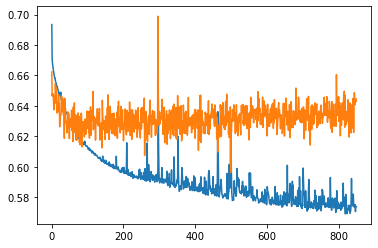

In [56]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
plt.savefig("E:\\NN\\"+modelName+"_history.png")

In [58]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\CoActivityAndDff2speed_1l_10uadam\assets


INFO:tensorflow:Assets written to: E:\CoActivityAndDff2speed_1l_10uadam\assets


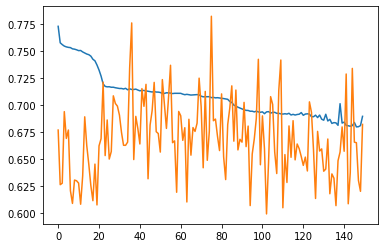

In [298]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
# plt.legend.show()
plt.savefig("E:\\NN\\LSTM_"+modelName+"_loss.png")

In [45]:
def loadLabel(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
    dictData = data.to_dict('records')
    labels = []
    for i in range(1,len(dictData)):
        labels.append(dictData[i]['label'])
        if i%butchSize==0:
            labels = np.stack(labels)
            yield (labels)
            labels = []
    f.close()


22/22 [==============================] - 5s 257ms/step


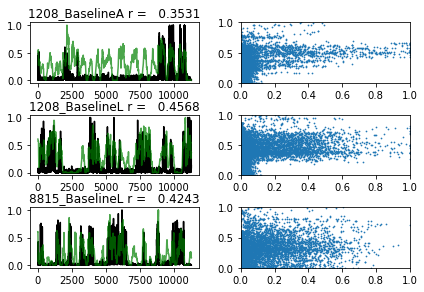

In [57]:
model =  tf.keras.models.load_model('E:\\'+modelName+'_bestWeights.h5',custom_objects={'correlation_coefficient_loss':                   
correlation_coefficient_loss})
plotResultBySession(testData,save=True,saveName=modelName+'_test_data_bestWeights.png')

In [44]:
def plotResultBySession(data,save=False,saveName=""):
    fig, ax = plt.subplots(len(data.Session.unique()),2)
    fig.tight_layout()
    for i,s in enumerate(data.Session.unique()):
        testData2 = data[data.Session == s]
        y_hat = model.predict(loadTest(testData2,butchSize,N),verbose=1)
        y_hat = (y_hat-np.min(y_hat))/(np.max(y_hat)-np.min(y_hat))
        y = []
        for ind,(label) in enumerate(loadLabel(testData2,butchSize,N)):
            y = y+list(label)
        y = np.asarray(y,dtype='float')
        ax[i,0].plot(np.arange(0,np.max(y.shape)),y,label='y',color='k')
        ax[i,0].plot(np.arange(0,np.max(y_hat.shape)),y_hat,label='y^',color='g',alpha=.7)
        ax[i,0].set_title(s+" r = {0:8.4f}".format(sci.stats.pearsonr(y,y_hat[:,0])[0]))
        ax[i,1].scatter(y,y_hat,s=.5)
        ax[i,1].set_xlim(0, 1)
        ax[i,1].set_ylim(0, 1)
    if save:
        fig.savefig('E:\\LSTM_coActivity\\'+saveName,format='png')

22/22 [==============================] - 6s 261ms/step


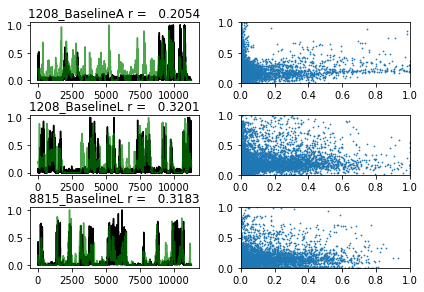

In [46]:
plotResultBySession(testData,save=True,saveName=modelName+'_test_data.png')

20/20 [==============================] - 5s 264ms/step


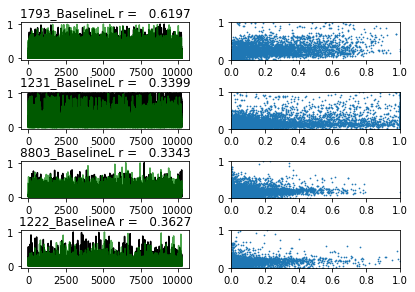

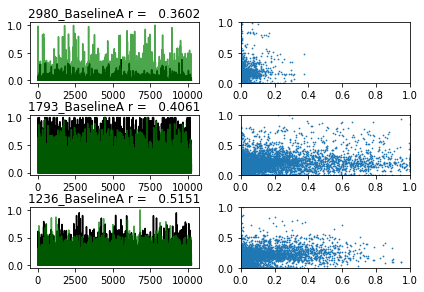

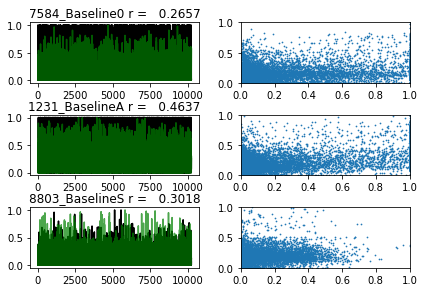

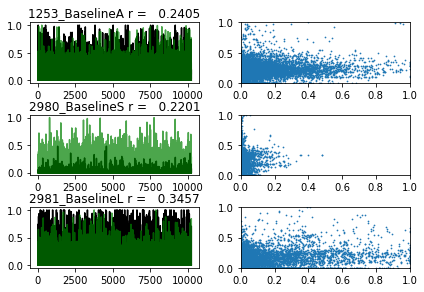

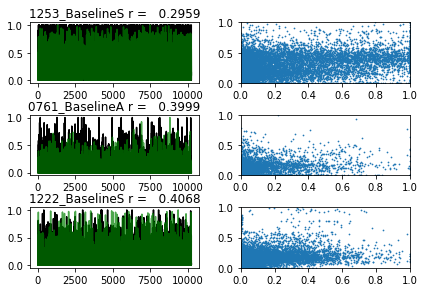

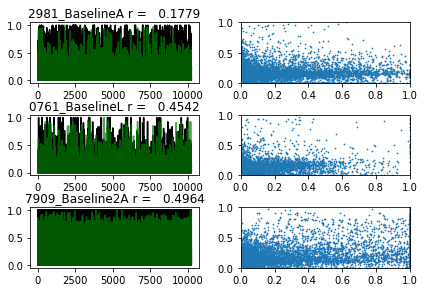

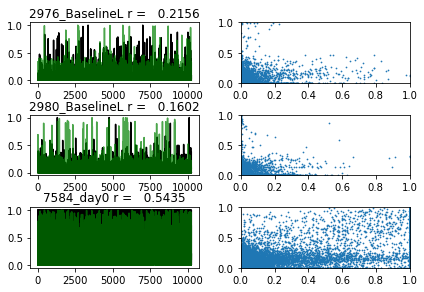

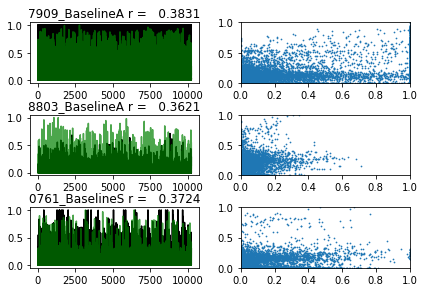

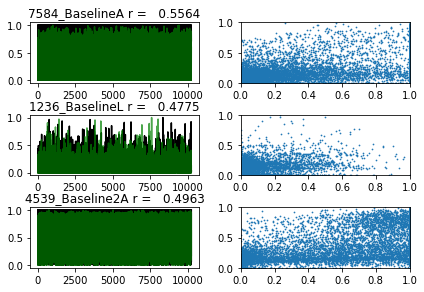

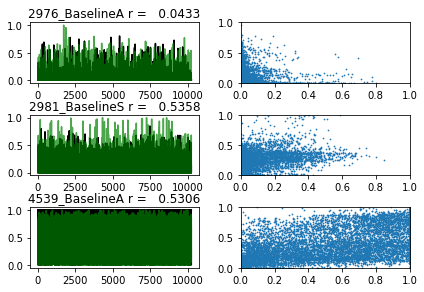

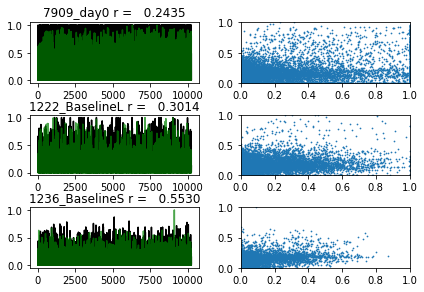

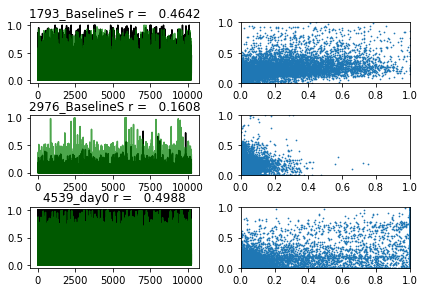

In [47]:
sess = []
for i,s in enumerate(trainData2.Session.unique()):
    sess.append(s)
    if i>0 and i%3==0:
        d = trainData2[trainData2.Session.isin(sess)]
        plotResultBySession(d, save=True,saveName=modelName+'_train_data_'+str(i)+'.png')
        sess = []

155/155 [==============================] - 10s 67ms/step


(0.0, 1.0)

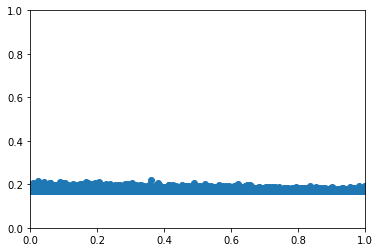

In [85]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
# trainData3 = trainData2.iloc[:1000,]
# testData2
y_hat = model.predict(loadTest(trainData2,butchSize,N),verbose=1)

y = []
for ind,(label) in enumerate(loadLabel(trainData2,butchSize,N)):
    y = y+list(label)

plt.scatter(y,y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)
print(sci.stats.pearsonr(np.asarray(y_hat,dtype='float')[:,0], np.asarray(y, dtype='float')))

3/3 [==============================] - 0s 90ms/step


(0.0, 1.0)

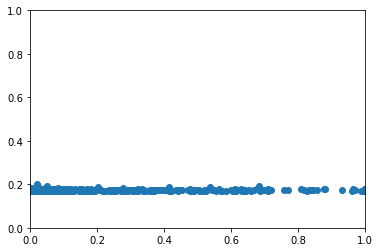

In [87]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
# trainData3 = trainData2.iloc[:1000,]
# testData2
y_hat = model.predict(loadTest(validate2,butchSize,N),verbose=1)

y = []
for ind,(label) in enumerate(loadLabel(validate2,butchSize,N)):
    y = y+list(label)

plt.scatter(y,y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)


In [88]:
# %matplotlib inline
# plt.plot(y[:400])
# plt.plot(y_hat[:400]*10-1.5)
sci.stats.pearsonr(np.asarray(y_hat,dtype='float')[:,0], np.asarray(y, dtype='float'))
# np.asarray(y_hat, dtype='float')[:,0].shape

(0.1542560552064443, 1.298143910798635e-05)

In [135]:
# N = 9
# dictdf = testData2.to_dict('records')
# for i in range(0,18,N):
#     print(pd.DataFrame(dictdf[i:i+N]),i,i+N)
f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
trainData2['label'] = trainData2.apply(lambda row: f[row.Session]['speed'][np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )
f.close()

In [95]:
def loadTrain(data,butchSize,N):
    with h5py.File('E:\\normalized_step2_processed.hdf5','r') as f:
    # sampleSize = batchSize/3
#         while True: 
        data = data.sample(frac=1)
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(1,len(dictData)):
            labels.append(dictData[i]['label'])
#                 dp = np.stack([f[dictData[i]['Session']]['ca'][dictData[i]['start']:dictData[i]['end']],
#                                np.mean(f[dictData[i]['Session']]['dff'][:,dictData[i]['start']:dictData[i]['end']],axis=0)]).T
            dp = [f[dictData[i]['Session']]['ca'][dictData[i]['start']:dictData[i]['end']],
                           np.mean(f[dictData[i]['Session']]['dff'][0:dictData[i]['maxN'],dictData[i]['start']:dictData[i]['end']],axis=0)]
            dp = np.stack(dp).T
            dataPoint.append(dp)
            if i%butchSize==0:# and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
#                     dataPoint = np.expand_dims(dataPoint, axis=2)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []


def loadTrain2(data,butchSize,N):
    with h5py.File('E:\\normalized_step2_processed.hdf5','r') as f:
    # sampleSize = batchSize/3
        while True: 
            data = data.sample(frac=1)
            dictData = data.to_dict('records')
            labels = []
            dataPoint =[]
            for i in range(1,len(dictData)):
                labels.append(dictData[i]['label'])
                dp = [f[dictData[i]['Session']]['ca'][dictData[i]['start']:dictData[i]['end']]]
                dp.append(np.mean(f[dictData[i]['Session']]['dff'][0:dictData[i]['maxN'],dictData[i]['start']:dictData[i]['end']],axis=0))           
                dp = np.stack(dp).T
                dataPoint.append(dp)
                if i%butchSize==0:# and i>0:
                    labels = np.stack(labels)
                    dataPoint = np.stack(dataPoint)
    #                     dataPoint = np.expand_dims(dataPoint, axis=2)
                    yield (dataPoint,labels)
                    labels = []
                    dataPoint = []


    
    
# def loadTrain(data,butchSize,N):
#     f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
#     # sampleSize = batchSize/3
# #     while True: 
#     data.sample(frac=1)
#     for i, g in data.groupby(np.arange(len(data)) // butchSize):
#         batch = g
#         labels = batch.label
#         labels = np.stack(labels.values)
#         dataPoint = batch.apply(lambda row: f[row.Session]['dff'][:,row.start:row.end].T, axis=1).values
#         dataPoint = [np.mean(row[:,np.random.randint(0,row.shape[0],size=N)],axis=1,keepdims=True) for row in dataPoint]
#         try:
#             dataPoint = np.stack(dataPoint)
#         except:
#             continue
#         yield (dataPoint,labels)
#     f.close()

     
trainData2 = trainData.sample(100000)  

y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain2(trainData2.iloc[:100000],10,N))):
    y = y+list(label)

y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain(trainData2.iloc[:100000],10,N))):
    y = y+list(label)


# plt.plot(y)

9999it [07:47, 21.38it/s]
9999it [07:46, 21.44it/s]


In [387]:
def loadTrain3(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed.hdf5','r') as f:
    # sampleSize = batchSize/3
#     while True: 
        data.sample(frac=1)
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(len(dictData)):
            labels.append(dictData[i]['label'])
            n,c = np.unique(np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N)),return_counts=True)
            dp = np.sum(f[dictData[i]['Session']]['dff'][n,dictData[i]['start']:dictData[i]['end']].T*c,axis=1,keepdims=True)/N
            dataPoint.append(dp)
            if i%butchSize==0 and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []
    
y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain3(trainData2.iloc[:100000],10,N))):
    y = y+list(label)


9999it [03:44, 44.55it/s]


In [380]:
with h5py.File('E:\\normalized_Ca_Speed.hdf5','r') as f: 
    n = np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N))
    n,c = np.unique(n,return_counts=True)
    print(f[dictData[i]['Session']]['dff'][n,:].T*c)

[[0.73899053 0.68311337 0.28387812 ... 0.41127712 0.46345011 0.32855268]
 [0.74808939 0.68733521 0.29657809 ... 0.42558941 0.44989046 0.31903619]
 [0.74468246 0.7056513  0.28962509 ... 0.44181902 0.46635848 0.3324495 ]
 ...
 [0.02433376 0.02971494 0.18222508 ... 0.02073476 0.02753908 0.02340979]
 [0.02077163 0.03944054 0.19441334 ... 0.00972384 0.         0.01699147]
 [0.01643481 0.03631539 0.20808202 ... 0.01158879 0.02376598 0.0125454 ]] [1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 3 1 3 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 3 3 1 2 1 1 4 1 1 1 1 1 2 1 1 1 1
 1 1 2 1]


In [243]:
import keras_tuner as kt
from keras_tuner import HyperModel as hp
from keras_tuner.tuners import RandomSearch

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('numUnits', min_value=5, max_value=100, step=5), input_shape=(segN, N)))#, return_sequences = True))
    model.add(Dropout(rate=hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.20,step=0.05,)))
    model.add(Dense(1))
    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
    return model

In [252]:
tuner = kt.Hyperband(
    model_builder,
    max_epochs=50,
    objective='val_mse',
    seed=1,
    executions_per_trial=2,
    directory='hyperband',
    project_name='LSTMsmooth'
)
cb = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)]


INFO:tensorflow:Reloading Oracle from existing project hyperband\LSTMsmooth\oracle.json


INFO:tensorflow:Reloading Oracle from existing project hyperband\LSTMsmooth\oracle.json


In [253]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

trainData2 = trainData.sample(frac=0.1) #to run this faster, just see if we get anything
validate2 = validate.sample(3000)
stepTrain=len(trainData2)//butchSize #just to test something is happening
stepValidate=len(validate2)//butchSize


tuner.search(loadTrain(trainData2,butchSize,N),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate2,butchSize,N),
                    validation_steps=stepValidate,
                    epochs=100)

Trial 75 Complete [00h 05m 34s]
val_mse: 0.06621589884161949

Best val_mse So Far: 0.06536858901381493
Total elapsed time: 02h 34m 09s

Search: Running Trial #76

Hyperparameter    |Value             |Best Value So Far 
numUnits          |10                |90                
dropout           |0.1               |0.25              
tuner/epochs      |17                |50                
tuner/initial_e...|0                 |17                
tuner/bracket     |1                 |2                 
tuner/round       |0                 |2                 

Epoch 1/17
66/66 [==============================] - 11s 151ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 2/17
66/66 [==============================] - 10s 147ms/step - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 3/17
66/66 [==============================] - 10s 152ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 4/17
66/66 [====================

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()